In [1]:
import tensorflow

In [2]:
import numpy as np
import h5py

import tensorflow as tf 
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, LeakyReLU, ReLU, Input, Concatenate
from tensorflow.keras.models import Model 
from tensorflow.keras.optimizers import Adam 
from sklearn.model_selection import train_test_split

In [3]:
PATH = r"/Users/suyashsachdeva/Desktop/gsoc_data.hdf5"
with h5py.File(PATH, 'r') as f:
    data = f['X_jets'][:]


In [4]:
dataset = np.zeros((data.shape[0], 128, 128, 3))
for c in range(data.shape[0]):
    dataset[c, 1:126, 1:126, :] = data[c]

In [5]:
dataset = dataset[:10000]

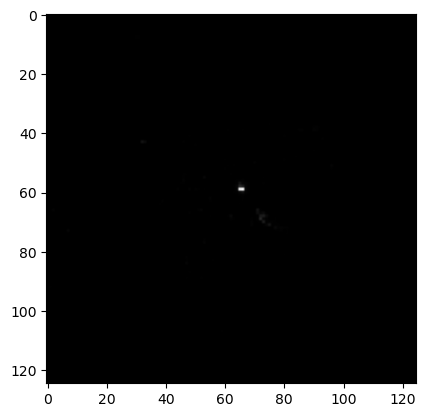

In [6]:
import matplotlib.pyplot as plt 
plt.imshow(data[1, :, :, 1], cmap="grey")

In [7]:
from tensorflow.keras.layers import GlobalAveragePooling2D, Reshape, Dense, multiply, Input, Conv2D, Conv2DTranspose, Concatenate, LeakyReLU, ReLU

def squeeze_excite_block(input, ratio=16):
    '''Create a squeeze and excitation block.'''
    init = input
    channel_axis = -1  # Channel axis
    filters = init.shape[channel_axis]
    se_shape = (1, 1, filters)
    
    se = GlobalAveragePooling2D()(init)
    se = Reshape(se_shape)(se)
    se = Dense(filters , activation='relu', kernel_initializer='he_normal', use_bias=False)(se)
    se = Dense(filters, activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(se)
    
    x = multiply([init, se])
    return x
def ConvLayer(x, filters, kernel, strides=1):
    x1 = Conv2D(filters//4, kernel+2, padding="same", strides=strides)(x)
    x1 = squeeze_excite_block(x1)
    
    x2 = Conv2D(filters//4, kernel-2, padding="same", strides=strides)(x)
    x2 = squeeze_excite_block(x2)
    
    x3 = Conv2D(filters//2, kernel, padding="same", strides=strides)(x)
    x3 = squeeze_excite_block(x3)
    
    return Concatenate()([x1, x2, x3])

def TranLayer(x, filters, kernel, strides=1):
    x1 = Conv2DTranspose(filters//4, kernel+2, padding="same", strides=strides)(x)
    x1 = squeeze_excite_block(x1)
    
    x2 = Conv2DTranspose(filters//4, kernel-2, padding="same", strides=strides)(x)
    x2 = squeeze_excite_block(x2)
    
    x3 = Conv2DTranspose(filters//2, kernel, padding="same", strides=strides)(x)
    x3 = squeeze_excite_block(x3)
    
    return Concatenate()([x1, x2, x3])


def ConvBlock(x, filters, kernel, strides, gf, alpha):
    x0 = ConvLayer(x, filters, kernel)
    x = LeakyReLU(alpha)(x0)

    x = ConvLayer(x, filters, kernel)
    x = LeakyReLU(alpha)(x)

    filters = filters*gf
    x = ConvLayer(x+x0, filters, kernel, strides=strides)
    x = LeakyReLU(alpha)(x)
    return x, filters

def TransBlock(x, filters, kernel, strides, gf, alpha):
    filters = filters//gf
    x0 = TranLayer(x, filters, kernel, strides=strides)
    x = LeakyReLU(alpha)(x0)

    x = TranLayer(x, filters, kernel)
    x = LeakyReLU(alpha)(x)

    x = TranLayer(x+x0, filters, kernel)
    x = LeakyReLU(alpha)(x)
    return x, filters

def Autoencoder(inp, num_block=3, filters=16, kernel=3, strides=2, gf=2, alpha=0.1):
    inp = Input(inp)
    x = Conv2D(filters, 3, padding="same")(inp)
    x = LeakyReLU(alpha)(x)
    
    for _ in range(num_block):
        x, filters = ConvBlock(x, filters, kernel, strides, gf, alpha)

    for _ in range(num_block):
        x, filters = TransBlock(x, filters, kernel, strides, gf, alpha)

    x = Conv2DTranspose(3, kernel, padding="same")(x)
    x = ReLU()(x)

    model = Model(inputs=inp, outputs=x, name="autoencoder")
    return model 

model = Autoencoder((128, 128, 3))
model.summary()

2024-04-05 22:01:19.714017: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Max
2024-04-05 22:01:19.714043: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 96.00 GB
2024-04-05 22:01:19.714063: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 36.00 GB
2024-04-05 22:01:19.714090: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-04-05 22:01:19.714122: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        448 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu         │ (None, 128, 128,  │          0 │ conv2d[0][0]      │
│ (LeakyReLU)         │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │      1,604 │ leaky_re_lu[0][0] │
│                     │ 4)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │         68 │ leaky_re_lu[0][0] │
│                     │ 4)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │      1,160 │ leaky_re_lu[0][0] │
│                     │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 4)         │          0 │ conv2d_1[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 4)         │          0 │ conv2d_2[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 8)         │          0 │ conv2d_3[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 1, 1, 4)   │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 1, 1, 4)   │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_2 (Reshape) │ (None, 1, 1, 8)   │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1, 1, 4)   │         16 │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1, 1, 4)   │         16 │ reshape_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 1, 1, 8)   │         64 │ reshape_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1, 1, 4)   │         16 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1, 1, 4)   │         16 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 1, 1, 8)   │         64 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 128, 128,  │          0 │ conv2d_1[0][0],   │
│                     │ 4)                │            │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_1          │ (None, 128, 128,  │          0 │ conv2d_2[0][0], 

 Total params: 511,043 (1.95 MB)

 Trainable params: 511,043 (1.95 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# PSNR calculation function
def psnr(img1, img2):
  return tf.image.psnr(img1, img2, max_val=1.0)

# SSIM calculation function
def ssim(image1, image2):
    image1 = tf.image.convert_image_dtype(image1, tf.float32)
    image2 = tf.image.convert_image_dtype(image2, tf.float32)
    ssim = tf.image.ssim(image1, image2, max_val=1.0)
    return ssim

In [9]:
traindata, testdata = train_test_split(dataset, test_size=0.2)
traindata, validata = train_test_split(traindata, test_size=0.25)

In [10]:
l2_reg = tf.keras.regularizers.l1(0.001)
for layer in model.layers:  
        layer.kernel_regularizer = l2_reg

In [11]:
def focal_loss(y_true, y_pred, alpha=0.25, gamma=2.0, epsilon=1e-6):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)  # Preventing division by zero
    pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
    pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
    return -tf.reduce_sum(alpha * tf.pow(1. - pt_1, gamma) * tf.math.log(pt_1)) \
           -tf.reduce_sum((1 - alpha) * tf.pow(pt_0, gamma) * tf.math.log(1. - pt_0))

def dice_loss(y_true, y_pred, smooth=1e-6):
    y_true_flat = tf.reshape(y_true, [-1])
    y_pred_flat = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_flat * y_pred_flat)
    union = tf.reduce_sum(y_true_flat) + tf.reduce_sum(y_pred_flat)
    dice = (2. * intersection + smooth) / (union + smooth)
    return 1 - dice

def iou(y_true, y_pred, smooth=1e-6):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred > 0.5, tf.float32) 
    intersection = tf.reduce_sum(y_true * y_pred)
    total = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
    union = total - intersection
    IoU = (intersection + smooth) / (union + smooth)
    return IoU

def loss(y_true, y_pred, weights={'bce': 1.0, 'iou': 1.0, 'focal': 1.0}):
    bce = tf.keras.losses.mae(y_true, y_pred)
    dice = dice_loss(y_true, y_pred)
    iou_loss = 1 - iou(y_true, y_pred)
    focal = focal_loss(y_true, y_pred)/(128*128)
    combined_loss = (weights['bce'] * bce)  + \
                    (weights['iou'] * iou_loss) + (weights['focal'] * focal)
    return combined_loss

In [12]:
history = []
for lr, batch in zip([1e-4, 5e-5, 3e-5, 1e-5], [256, 128, 64, 32]):
    model.compile(loss="mae", optimizer=tf.optimizers.Adam(learning_rate=lr), metrics=[ iou])
    history.append(model.fit(traindata, traindata, epochs=10, verbose=1, batch_size=batch, validation_data=[validata, validata], validation_batch_size=batch,))

Epoch 1/10


2024-04-05 22:01:33.102772: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


24/24 ━━━━━━━━━━━━━━━━━━━━ 99s 2s/step - iou: 1.5838e-09 - loss: 5.0441e-05 - val_iou: 1.6306e-09 - val_loss: 5.0212e-05
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - iou: 1.5714e-09 - loss: 5.0866e-05 - val_iou: 1.6306e-09 - val_loss: 5.0212e-05
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - iou: 1.5625e-09 - loss: 5.0912e-05 - val_iou: 1.6306e-09 - val_loss: 5.0212e-05
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - iou: 1.5669e-09 - loss: 5.0987e-05 - val_iou: 1.6306e-09 - val_loss: 5.0212e-05
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - iou: 1.5571e-09 - loss: 5.1379e-05 - val_iou: 1.6306e-09 - val_loss: 5.0212e-05
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - iou: 1.5544e-09 - loss: 5.1352e-05 - val_iou: 1.6306e-09 - val_loss: 5.0212e-05
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - iou: 1.5807e-09 - loss: 5.0553e-05 - val_iou: 1.6306e-09 - val_loss: 5.0212e-05
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - iou: 1.5819e-09 - loss: 5.0489e-05 

KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt
true = dataset[10100]
output = model(dataset[10100].reshape(-1, 128, 128, 3))

In [ ]:
plt.figure(figsize= (15, 3*5))

# Loop through each channel and create a subplot
for i in range(3):
    plt.subplot( 3, 2, i*2+1)  # 1 row, 3 columns, ith subplot
    plt.imshow(output[:, :, :, i][0], cmap='gray')  # Display ith channel
    plt.axis('off')  # Hide axes for clarity

    plt.subplot(3, 2, i*2+2)  # 1 row, 3 columns, ith subplot
    plt.imshow(true[:, :, i], cmap='gray')  # Display ith channel
    plt.axis('off')  # Hide axes for clarity

plt.show()